In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# Split validation set (10% of training data)
val_size = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

# Normalize inputs
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [4]:
x_val.shape

(6000, 784)

In [64]:
class NN:
  def __init__(self,input_shape,output_shape,n_hidden_layers,h_per_layer,activation_func="relu",loss_func="cross_entropy_loss",init_type="random"):
    self.input_shape = input_shape
    self.output_shape = output_shape
    self.n_h = n_hidden_layers
    self.k = h_per_layer
    self.weights,self.biases = self.weight_init(init_type)
    self.grad_weights = [0]*(self.n_h+1)
    self.grad_biases = [0]*(self.n_h+1)
    self.activation_func = activation_func
    self.loss_func = loss_func
  def activation(self,x):
    if self.activation_func == "relu":
      return np.maximum(0,x)
    elif self.activation_func == "tanh":
      return np.tanh(x)
    elif self.activation_func == "sigmoid":
      return 1/(1+np.exp(-x))
  def activation_grad(self,x):
    if self.activation_func == "relu":
      return np.where(x>0,1,0)
    elif self.activation_func == "tanh":
      return 1-np.tanh(x)**2
    elif self.activation_func == "sigmoid":
      s = 1/(1+np.exp(-x))
      return s*(1-s)
  def softmax(self,x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)
  def transpose(self,w):
    return np.array(w).T.tolist()
  def one_hot(self,y):
    return np.eye(self.output_shape)[y]
  def loss(self,y_hat,y_true):
    if self.loss_func == "cross_entropy_loss":
      y_hat = np.array(y_hat)
      y_true = np.array(y_true)
      epsilon = 1e-10  # Prevent log(0)
      return -np.sum(y_true * np.log(y_hat + epsilon)) / y_hat.shape[0]
    elif self.loss_func == "squared_error":
      return np.sum((y_hat-y_true)**2)
  def accuracy(self,y_hat,y_true):
    return np.sum(y_hat==y_true)/len(y_true)
  def weight_init(self, init_type="random"):
    weights = []
    biases = []
    if init_type == "random":
        weights.append(np.random.randn(self.input_shape, self.k))
        biases.append(np.random.randn(self.k, 1))
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k))
            biases.append(np.random.randn(self.k, 1))
        weights.append(np.random.randn(self.k, self.output_shape))
        biases.append(np.random.randn(self.output_shape, 1))
    elif init_type == "xavier":
        # Xavier Initialization
        weights.append(np.random.randn(self.input_shape, self.k) * np.sqrt(2 / (self.input_shape + self.k)))
        biases.append(np.zeros((self.k, 1)))  # Biases are usually initialized to 0
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k) * np.sqrt(2 / (self.k + self.k)))
            biases.append(np.zeros((self.k, 1)))
        weights.append(np.random.randn(self.k, self.output_shape) * np.sqrt(2 / (self.k + self.output_shape)))
        biases.append(np.zeros((self.output_shape, 1)))
    return weights, biases

  def basic_optimizer(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    if not hasattr(self, "m_weights"):
        # Initialize moment estimates as numpy arrays
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.t = 0  # Time step

    self.t += 1  # Increment time step

    for i in range(len(self.weights)):
        # Convert gradients to numpy arrays
        grad_w = np.array(self.grad_weights[i])
        grad_b = np.array(self.grad_biases[i])

        # Compute biased first moment estimate
        self.m_weights[i] = beta1 * self.m_weights[i] + (1 - beta1) * grad_w
        self.m_biases[i] = beta1 * self.m_biases[i] + (1 - beta1) * grad_b

        # Compute biased second moment estimate
        self.v_weights[i] = beta2 * self.v_weights[i] + (1 - beta2) * (grad_w ** 2)
        self.v_biases[i] = beta2 * self.v_biases[i] + (1 - beta2) * (grad_b ** 2)

        # Bias-corrected moment estimates
        m_w_hat = self.m_weights[i] / (1 - beta1 ** self.t)
        v_w_hat = self.v_weights[i] / (1 - beta2 ** self.t)
        m_b_hat = self.m_biases[i] / (1 - beta1 ** self.t)
        v_b_hat = self.v_biases[i] / (1 - beta2 ** self.t)

        # Update weights and biases
        self.weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        self.biases[i] -= lr * (np.sum(m_b_hat, axis=1, keepdims=True)) / (np.sqrt(np.sum(v_b_hat, axis=1, keepdims=True)) + epsilon)

  def forward(self,x,y):
    a_list = [0]*(self.n_h+2)
    h_list = [0]*(self.n_h+2)
    h = self.transpose(x)
    h_list[0] = h
    for i in range(self.n_h):
      a_list[i+1] = np.dot(self.transpose(self.weights[i]),h_list[i])+self.biases[i]
      h_list[i+1] = self.activation(a_list[i+1])
    a_list[self.n_h+1] = np.dot(self.transpose(self.weights[self.n_h]),h_list[self.n_h])+self.biases[self.n_h]
    y_hat = self.transpose(self.softmax(a_list[self.n_h+1]))
    h_list[self.n_h+1] = y_hat
    return a_list,h_list
  def backward(self,a_list,h_list,y):
    a_grad_list = [0]*(self.n_h+2)
    h_grad_list = [0]*(self.n_h+2)
    y_hat = h_list[self.n_h+1]
    if self.loss_func == "cross_entropy_loss": #gradient wrt output layer
      a_grad = self.transpose(y_hat - self.one_hot(y))
    elif self.loss_func == "squared_error":
      a_grad = 2*(np.argmax(y_hat,axis=0) - y)
    a_grad_list[-1] = a_grad
    for k in range(self.n_h,-1,-1): # gradient wrt hiddden layers
      h_grad = np.dot(self.weights[k],a_grad_list[k+1])
      h_grad_list[k] = h_grad
      a_grad = np.multiply(h_grad,self.activation_grad(a_list[k]))
      a_grad_list[k] = a_grad
      self.grad_weights[k] = self.transpose(np.dot(a_grad_list[k+1],self.transpose(h_list[k]))) #gradients wrt parameters
      self.grad_biases[k] = np.sum(a_grad_list[k+1],axis=0, keepdims=True)
  def train(self,x_train,y_train,x_val,y_val,lr,epochs):
    train_loss_list = []
    train_acc_list = []
    for i in range(epochs):
      a_list_train,h_list_train = self.forward(x_train,y_train) # forward pass
      print("forward pass done")
      self.backward(a_list_train,h_list_train,y_train) # backward pass
      print("backward pass done")
      self.basic_optimizer(lr=lr) # updating weights
      print("optimizer done")
      y_hat = h_list_train[self.n_h+1]
      train_loss = self.loss(y_hat,self.one_hot(y_train))
      train_acc = self.accuracy(np.argmax(np.array(y_hat),axis=1),y_train)
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc)
      print("Train Loss: ",train_loss,"Train Accuracy: ",train_acc)
    return train_loss_list,train_acc_list
      # a_list_val,h_list_val = self.forward(x_val,y_val)
      # y_hat_val = h_list_val[self.n_h+1]
      # val_loss = self.loss(y_hat_val,self.one_hot(y_val))
      # val_acc = self.accuracy(np.argmax(np.array(y_hat_val),axis=1),y_val)
      # print("Epoch: ",i+1,"Train Loss: ",train_loss,"Train Accuracy: ",train_acc,"Val Loss: ",val_loss,"Val Accuracy: ",val_acc)

In [65]:
# Hyperparameters
num_hid_layers = 3
hid_layer_size = 64  # Changeable number of layers
weight_init = 'xavier'  # Options: 'random', 'xavier'
activation = 'relu'  # Options: 'sigmoid', 'tanh', 'relu'
#l2_reg = 0.0005  # L2 regularization strength
lr = 1e-3  # Options: 1e-3, 1e-4
#batch_size = 32  # Options: 16, 32, 64
epochs = 20  # Options: 5, 10
#optimizer = 'sgd'  # Options: 'sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam'
loss_func = 'cross_entropy_loss'  # Options: 'cross_entropy_loss', 'squared_error'
# self,input_shape,output_shape,n_hidden_layers,h_per_layer,activation_func="ReLU",loss_func="cross_entropy_loss"
# Initialize and train the model
nn = NN(input_shape=784,output_shape=10,n_hidden_layers=num_hid_layers, h_per_layer=hid_layer_size, activation_func=activation, init_type=weight_init, loss_func=loss_func)
train_loss_list,train_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=epochs,lr=lr)

forward pass done
backward pass done
optimizer done
Train Loss:  2.335658931536413 Train Accuracy:  0.13257407407407407
forward pass done
backward pass done
optimizer done
Train Loss:  2.2477942573880134 Train Accuracy:  0.21207407407407408
forward pass done
backward pass done
optimizer done
Train Loss:  2.189446736568144 Train Accuracy:  0.2710740740740741
forward pass done
backward pass done
optimizer done
Train Loss:  2.114079329044668 Train Accuracy:  0.3088148148148148
forward pass done
backward pass done
optimizer done
Train Loss:  2.0267275773009312 Train Accuracy:  0.3187962962962963
forward pass done
backward pass done
optimizer done
Train Loss:  1.9436061268028222 Train Accuracy:  0.3310740740740741
forward pass done
backward pass done
optimizer done
Train Loss:  1.86153544327104 Train Accuracy:  0.38625925925925925
forward pass done
backward pass done
optimizer done
Train Loss:  1.7741918805641694 Train Accuracy:  0.4597407407407407
forward pass done
backward pass done
optim

Text(0, 0.5, 'Acc')

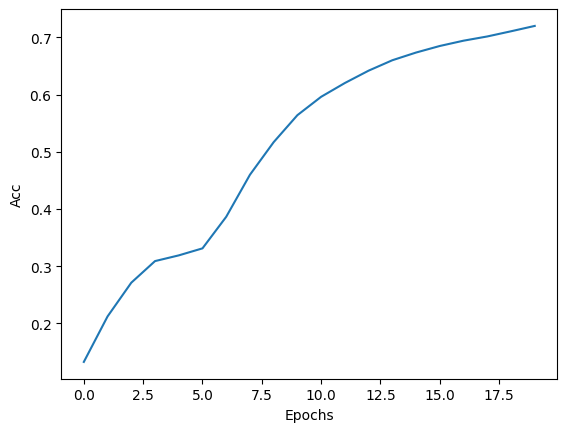

In [66]:
plt.plot(train_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Acc")

Text(0, 0.5, 'Loss')

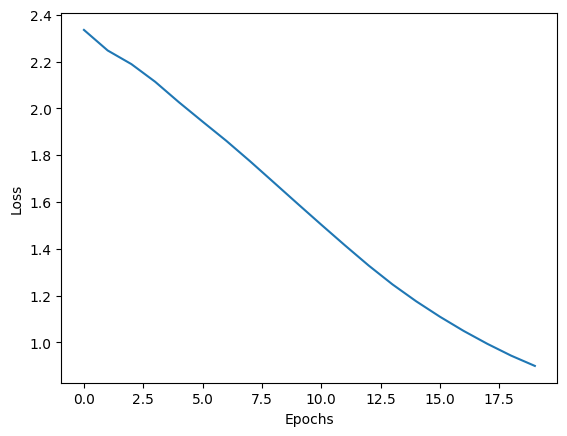

In [67]:
plt.plot(train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")